In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW,BertTokenizerFast,Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader
import re
import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score
from transformers_interpret import SequenceClassificationExplainer

## Read and clean data

In [ ]:
df = pd.read_csv("/content/sentiment_data.csv")
df

,text,sentiment
0,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,Positive
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive
3,@Mo_Fat7 النهضة في فتيل 😂,Positive
4,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,Neutral
...,...,...
54996,#تصنيف_دايم_للتخصصات_الصحيه٥ بالامس تحدثونا عن...,Neutral
54997,@MCgovSA اتمنى تحلون المشكله وش يعني لما نلغ...,Neutral
54998,@mhrsd_care السلام عليكم \n\nعندي استفسار يا ا...,Neutral
54999,@mhrsd_care حاب استفسر اذا منشآتي من ضمن المنش...,Neutral


In [ ]:
df.info

<bound method DataFrame.info of                                                     text sentiment
0      @nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...  Positive
1      "الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...   Neutral
2      الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...  Positive
3                              @Mo_Fat7 النهضة في فتيل 😂  Positive
4      @halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...   Neutral
...                                                  ...       ...
54996  #تصنيف_دايم_للتخصصات_الصحيه٥ بالامس تحدثونا عن...   Neutral
54997  @MCgovSA  اتمنى تحلون المشكله وش  يعني لما نلغ...   Neutral
54998  @mhrsd_care السلام عليكم \n\nعندي استفسار يا ا...   Neutral
54999  @mhrsd_care حاب استفسر اذا منشآتي من ضمن المنش...   Neutral
55000  @mhrsd_care تقولون كلمونا على شبكة التواصل ولا...   Neutral

[55001 rows x 2 columns]>

In [ ]:
df = df.astype(str)
df.drop_duplicates(inplace=True)

In [ ]:
class preprocessing:

  def normalize(sentence):
    '''
    Argument:
        string of words
    return:
        string of words but standardize the words
    '''
    sentence = re.sub("[إأآا]", "ا", sentence)
    sentence = re.sub("ى", "ي", sentence)
    sentence = re.sub("ؤ", "ء", sentence)
    sentence = re.sub("ئ", "ء", sentence)
    sentence = re.sub("ة", "ه", sentence)
    sentence = re.sub("گ", "ك", sentence)
    sentence = re.sub("\"|#|$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|:|;|<|=|>|[|\\|]|\n|^|`|{||}~","",sentence)
    return sentence

  def remove_punkt(sentence):
    '''
      Argument:
          string of words
      return:
          string of words but after removing punctuations
    '''
    text = re.sub(r'[^\w\s]',"",sentence)
    return text

  def preprocess(sentence):
    '''
    Argument:
        string of words
    return:
        string of words after cleaning
    '''
    clean = preprocessing.normalize(sentence)
    clean = preprocessing.remove_punkt(clean)
    return clean

In [ ]:
for i in range(5):
    for i in range(len(df)):
        if "https" in df['text'].iloc[i]:
            the_at_index = df['text'].iloc[i].find("https")
            for the_space_index in range(the_at_index,len(df['text'].iloc[i])):

                if df['text'].iloc[i][the_space_index] == " ":

                    df['text'].iloc[i] = df['text'].iloc[i][0 : the_at_index : ] + df['text'].iloc[i][ the_space_index+1 : :]
                    break

                elif(the_space_index == len(df['text'].iloc[i])-1):
                    the_space_index = len(df['text'].iloc[i])-1
                    df['text'].iloc[i] = df['text'].iloc[i][0 : the_at_index : ]

                    break

In [ ]:
for i in range(3):
    for i in range(len(df)):
        for the_at_index in range(len(df['text'].iloc[i])):
            if df['text'].iloc[i][the_at_index] == '@':
                for the_space_index in range(the_at_index,len(df['text'].iloc[i])):

                    if df['text'].iloc[i][the_space_index] == " ":
                        df['text'].iloc[i] = df['text'].iloc[i][0 : the_at_index : ] + df['text'].iloc[i][ the_space_index+1 : :]
                        break

                    elif(the_space_index == len(df['text'].iloc[i])-1):
                        df['text'].iloc[i] = df['text'].iloc[i][0 : the_at_index : ]
                        break

                break

In [ ]:
df

,text,sentiment
0,والله حسب الأرقام سيكون مخيب للآمال\nولكن الأه...,Positive
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive
3,النهضة في فتيل 😂,Positive
4,ليس حباً في ايران بقدر ماهو نكايه بترامب وحزبه,Neutral
...,...,...
54996,#تصنيف_دايم_للتخصصات_الصحيه٥ بالامس تحدثونا عن...,Neutral
54997,اتمنى تحلون المشكله وش يعني لما نلغي الطلب ي...,Neutral
54998,السلام عليكم \n\nعندي استفسار يا الغالي كل ما ...,Neutral
54999,حاب استفسر اذا منشآتي من ضمن المنشآت المستثناة...,Neutral


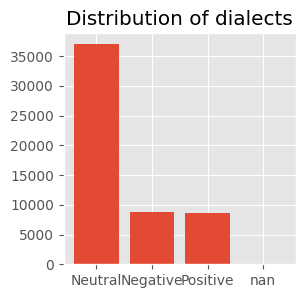

In [ ]:

fig = plt.figure(figsize =(3, 3))
plt.bar(df['sentiment'].value_counts().index, df['sentiment'].value_counts());
plt.title("Distribution of dialects");

In [ ]:
df = df[df["sentiment"].str.contains("nan")==False]

In [ ]:
df['sentiment'].value_counts()

Neutral     36983
Negative     8792
Positive     8617
Name: sentiment, dtype: int64

In [ ]:
df['sentiment'] = df['sentiment'].map({'Neutral': 0, 'Positive': 1, 'Negative': 2})

<ipython-input-50-e5d25c70da30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map({'Neutral': 0, 'Positive': 1, 'Negative': 2})


In [ ]:
df.head()

,text,sentiment
0,والله حسب الأرقام سيكون مخيب للآمال\nولكن الأه...,1
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",0
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,1
3,النهضة في فتيل 😂,1
4,ليس حباً في ايران بقدر ماهو نكايه بترامب وحزبه,0


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv02-twitter', num_labels=len(df['sentiment'].unique()))
tokenizer = BertTokenizerFast.from_pretrained('aubmindlab/bert-base-arabertv02-twitter')

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmi

In [ ]:
train = df[0:int(0.80*len(df))]
val = df[int(0.80*len(df)):int(0.90*len(df))]
test = df[int(0.90*len(df)):int(len(df))]

print(train.shape)
print(val.shape)
print(test.shape)

(43513, 2)
(5439, 2)
(5440, 2)


In [ ]:
train_encodings = tokenizer(train['text'].to_list(), truncation=True, padding=True, max_length=70)
val_encodings = tokenizer(val['text'].to_list(), truncation=True, padding=True, max_length=70)
test_encodings = tokenizer(test['text'].to_list(), truncation=True, padding=True, max_length=70)

In [ ]:
train_labels = train['sentiment']
val_labels = val['sentiment']
test_labels = test['sentiment']

In [ ]:
class DialectsDataset(Dataset):
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels.to_list()

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [ ]:
ds_train = DialectsDataset(train_encodings, train_labels)
ds_val =  DialectsDataset(val_encodings, val_labels)
ds_test =  DialectsDataset(test_encodings, test_labels)

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'accuracy': acc,
  }

In [ ]:
training_args = TrainingArguments(
    output_dir='results',
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.470500,0.432208,0.815959
2,0.355600,0.462586,0.818901


TrainOutput(global_step=1360, training_loss=0.38510564916274126, metrics={'train_runtime': 1028.5195, 'train_samples_per_second': 84.613, 'train_steps_per_second': 1.322, 'total_flos': 3130546055437080.0, 'train_loss': 0.38510564916274126, 'epoch': 2.0})

In [ ]:
preds = trainer.predict(ds_test)

In [ ]:
y_pred = [np.argmax(i, axis=-1) for i  in preds.predictions]
y_test = ds_test.labels

In [ ]:
accuracy_score(y_test, y_pred)

0.8983455882352941

In [ ]:
cls_explainer = SequenceClassificationExplainer(
    model,
    tokenizer)

def interpret(explainer,text,TrueClass,name):
  word_attributions = explainer(text)
  explainer.visualize(name,true_class=TrueClass)
  return word_attributions

In [ ]:
word_attributions = interpret(cls_explainer,"مش بحب كدة",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_0 (0.59),LABEL_0,-1.33,[CLS] مش بحب كد ##ة [SEP]


In [ ]:

word_attributions = interpret(cls_explainer,"حلو الجو ده",1,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.94),LABEL_1,1.36,[CLS] حلو الجو ده [SEP]


In [ ]:
word_attributions = interpret(cls_explainer,"جميلة ",3,'exp')

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_1 (0.76),LABEL_1,1.00,[CLS] جميلة [SEP]
